### Ιωάννης Δασκαλόπουλος

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from scipy.stats import norm, skew #for some statistics
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import itertools
import math

%matplotlib inline

## Load the data

We will start by loading the data from the csv file

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


## Remove ID (Keep ID Vector for Submission Purposes)

Next we drop the ID column as we do not want it to be used for our predictions<br>
We keep the test ID to attach it with our predictions to create the final submission file

In [3]:
test_ID = test['Id']
train = train.drop('Id', axis=1)
test = test.drop('Id', axis=1)

train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

## Changing numerical into categorical values

By reading the data description we can find that there are some columns which are written as numerical (because they contain numbers only) but they should be viewed as categorical

In [4]:
train['MSSubClass'] = train['MSSubClass'].apply(str)
train['OverallCond'] = train['OverallCond'].astype(str)
train['YrSold'] = train['YrSold'].astype(str)
train['MoSold'] = train['MoSold'].astype(str)
test['MSSubClass'] = test['MSSubClass'].apply(str)
test['OverallCond'] = test['OverallCond'].astype(str)
test['YrSold'] = test['YrSold'].astype(str)
test['MoSold'] = test['MoSold'].astype(str)

## Describe and Split DTypes

We will now split the data into numerical and categorical values so that we can view them explicitly for missing values

In [5]:
train.dtypes.value_counts()

object     47
int64      30
float64     3
dtype: int64

In [6]:
int_columns = train.select_dtypes(include=["int64", "float64"]).copy()
test_int_columns = test.select_dtypes(include=["int64", "float64"]).copy()
object_columns = train.select_dtypes(include=["object"]).copy()
test_object_columns = test.select_dtypes(include=["object"]).copy()

# Handle Categorical Data

## Fill Missing Categorical Data

First, we will visualize the missing categorical data

Text(0.5,1,'Percent missing data by feature')

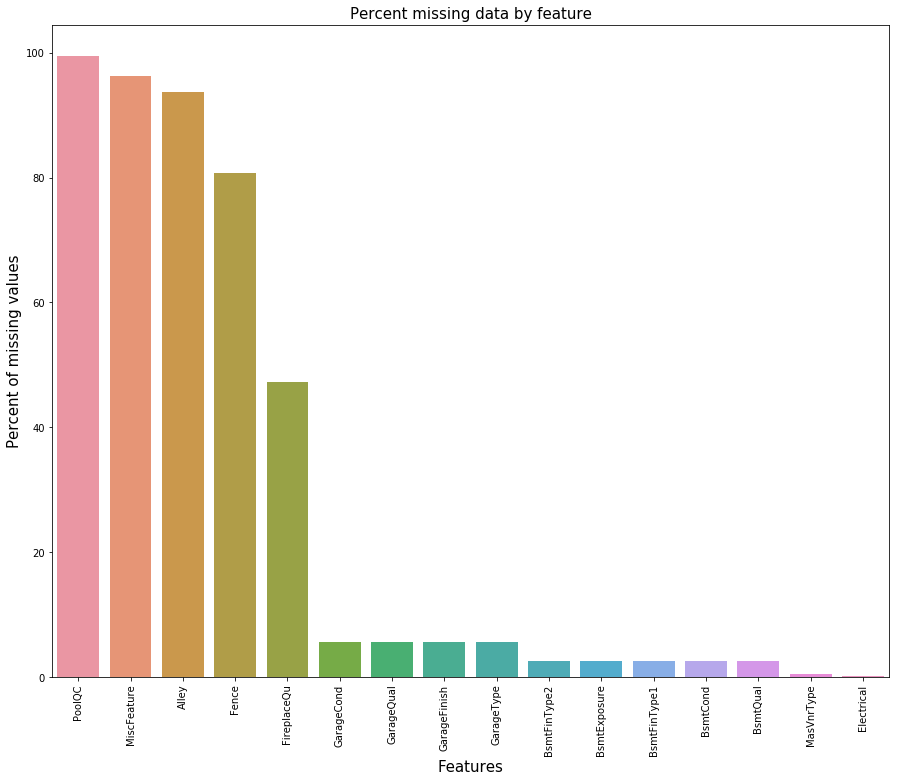

In [7]:
missing_categorical_train = (object_columns.isnull().sum() / len(object_columns)) * 100
missing_categorical_train = missing_categorical_train.drop(missing_categorical_train[missing_categorical_train == 0].index).sort_values(ascending=False)
missing_categorical_train = pd.DataFrame({'Missing Ratio' :missing_categorical_train})

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=missing_categorical_train.index, y=missing_categorical_train['Missing Ratio'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [8]:
missing_categorical_train

,Missing Ratio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
GarageCond,5.547945
GarageQual,5.547945
GarageFinish,5.547945
GarageType,5.547945
BsmtFinType2,2.602740


Now it it time to fill the missing data after reading their descriptions.<br>
For the first for loop we fix the data where NaN should really be none as they do not possess this characteristic.<br>
The second for loop doesn't have this description so we will guess by assigning the dominant value for each column<br>
For the functional column the missing value is Typ (Typical)<br>
And lastly the Utilities column does not hold any information as all entries are AllPub apart from other 3 (Including 2 NaN)

In [9]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','PoolQC','MiscFeature','Alley','Fence','FireplaceQu',
           'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','MasVnrType','MSSubClass'):
    object_columns[col] = object_columns[col].fillna('None')
for col in ('MSZoning','Electrical','KitchenQual','Exterior1st','Exterior2nd','SaleType'):
    object_columns[col] = object_columns[col].fillna(object_columns[col].mode()[0])
object_columns["Functional"] = object_columns["Functional"].fillna("Typ")
object_columns = object_columns.drop(['Utilities'], axis=1)

We continue by doing the exact same steps for test

Text(0.5,1,'Percent missing data by feature')

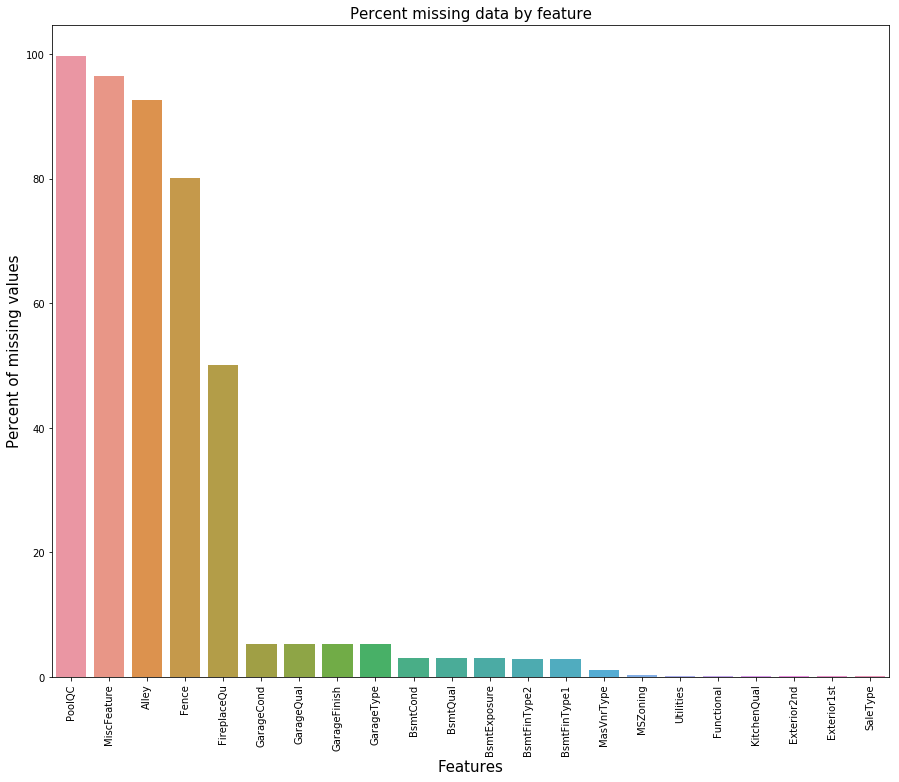

In [10]:
missing_categorical_test = (test_object_columns.isnull().sum() / len(test_object_columns)) * 100
missing_categorical_test = missing_categorical_test.drop(missing_categorical_test[missing_categorical_test == 0].index).sort_values(ascending=False)
missing_categorical_test = pd.DataFrame({'Missing Ratio' :missing_categorical_test})

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=missing_categorical_test.index, y=missing_categorical_test['Missing Ratio'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [11]:
missing_categorical_test

,Missing Ratio
PoolQC,99.794380
MiscFeature,96.504455
Alley,92.666210
Fence,80.123372
FireplaceQu,50.034270
GarageCond,5.346127
GarageQual,5.346127
GarageFinish,5.346127
GarageType,5.209047
BsmtCond,3.084304


In [12]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',"PoolQC","MiscFeature","Alley","Fence","FireplaceQu",
           'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','MasVnrType','MSSubClass'):
    test_object_columns[col] = test_object_columns[col].fillna('None')
for col in ('MSZoning','Electrical','KitchenQual','Exterior1st','Exterior2nd','SaleType'):
    test_object_columns[col] = test_object_columns[col].fillna(test_object_columns[col].mode()[0])
test_object_columns["Functional"] = test_object_columns["Functional"].fillna("Typ")
test_object_columns = test_object_columns.drop(['Utilities'], axis=1)

In [13]:
missing_categorical_train = (object_columns.isnull().sum() / len(object_columns)) * 100
missing_categorical_train = missing_categorical_train.drop(missing_categorical_train[missing_categorical_train == 0].index).sort_values(ascending=False)
missing_categorical_train = pd.DataFrame({'Missing Ratio' :missing_categorical_train})
missing_categorical_train

,Missing Ratio


In [14]:
missing_categorical_test = (test_object_columns.isnull().sum() / len(test_object_columns)) * 100
missing_categorical_test = missing_categorical_test.drop(missing_categorical_test[missing_categorical_test == 0].index).sort_values(ascending=False)
missing_categorical_test = pd.DataFrame({'Missing Ratio' :missing_categorical_test})
missing_categorical_test

,Missing Ratio


## Encode Categorical Data

Now that our data are ready we need to encode them into discrete numerical values so that the algorithms later will be able to read them<br>
We first merge train and test categorical data so that we will ensure each column's numbers will mean the exact same thing.<br>
Then we encode them and lastly divide them again into training and test set

In [15]:
train_test_cat = pd.concat((object_columns, test_object_columns)).reset_index(drop=True)

from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
lbl = LabelEncoder()
for c in cols: 
    lbl.fit(list(train_test_cat[c].values)) 
    train_test_cat[c] = lbl.transform(list(train_test_cat[c].values))

# shape        
print('Shape all_data: {}'.format(train_test_cat.shape))

Shape all_data: (2919, 46)


In [16]:
train_test_cat = pd.get_dummies(train_test_cat)
object_columns=train_test_cat[:object_columns.shape[0]]
test_object_columns=train_test_cat[object_columns.shape[0]:]
print(train_test_cat.shape)
print(object_columns.shape)
print(test_object_columns.shape)

(2919, 188)
(1460, 188)
(1459, 188)


# Handle Numerical Data

## Fill Missing Numerical Data

The exact same steps of visualizing and then replacing missing numerical data take place

Text(0.5,1,'Percent missing data by feature')

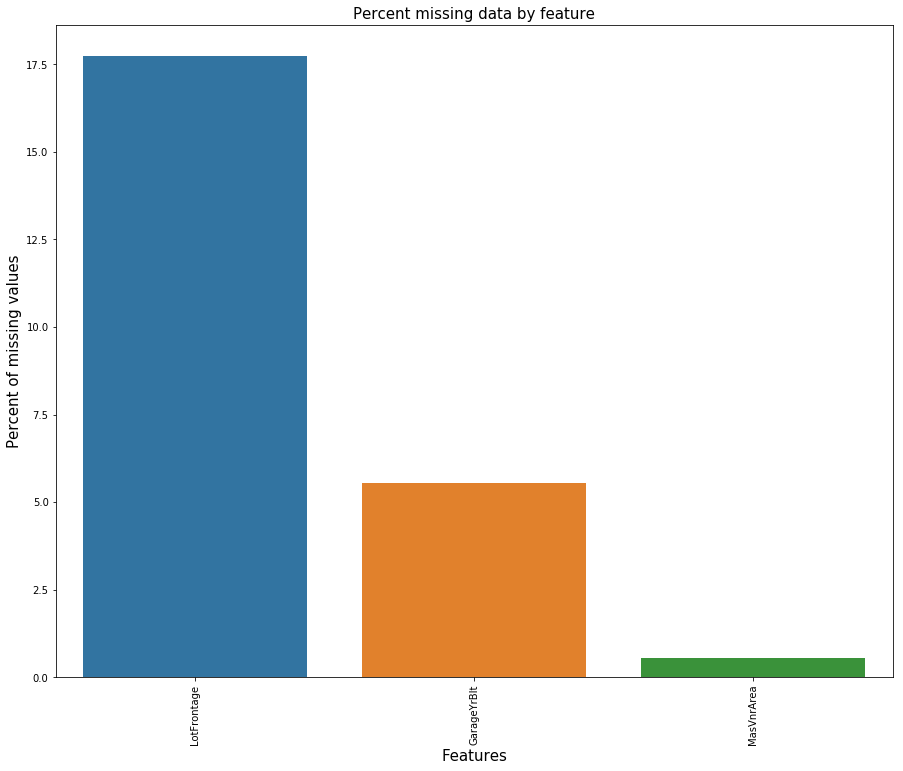

In [17]:
missing_numerical_train = (int_columns.isnull().sum() / len(int_columns)) * 100
missing_numerical_train = missing_numerical_train.drop(missing_numerical_train[missing_numerical_train == 0].index).sort_values(ascending=False)
missing_numerical_train = pd.DataFrame({'Missing Ratio' :missing_numerical_train})

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=missing_numerical_train.index, y=missing_numerical_train['Missing Ratio'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [18]:
missing_numerical_train

,Missing Ratio
LotFrontage,17.739726
GarageYrBlt,5.547945
MasVnrArea,0.547945


For anything that NaN means nothing we choose to impute with the median<br>
For anything else the features mean 0; That is, the contain none of this feature<br>
Actually the only value that really misses the median is Lot Frontage which is important and we will fill it later on

In [19]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars',"MasVnrArea"):
    int_columns[col] = int_columns[col].fillna(0)

Text(0.5,1,'Percent missing data by feature')

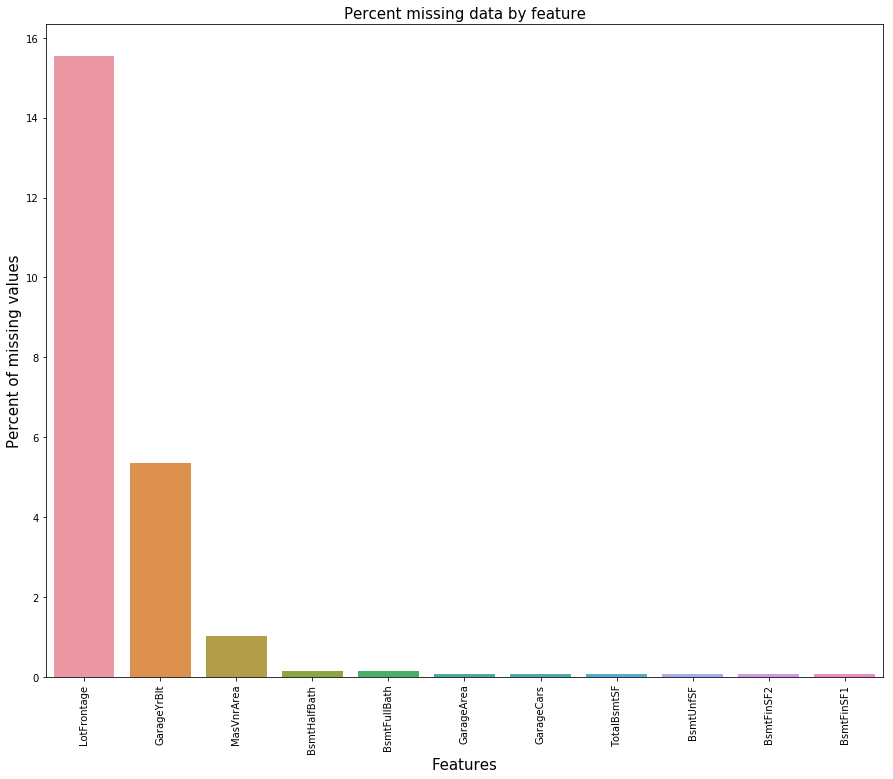

In [21]:
missing_numerical_test = (test_int_columns.isnull().sum() / len(test_int_columns)) * 100
missing_numerical_test = missing_numerical_test.drop(missing_numerical_test[missing_numerical_test == 0].index).sort_values(ascending=False)
missing_numerical_test = pd.DataFrame({'Missing Ratio' :missing_numerical_test})

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=missing_numerical_test.index, y=missing_numerical_test['Missing Ratio'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [22]:
missing_numerical_test

,Missing Ratio
LotFrontage,15.558602
GarageYrBlt,5.346127
MasVnrArea,1.028101
BsmtHalfBath,0.137080
BsmtFullBath,0.137080
GarageArea,0.068540
GarageCars,0.068540
TotalBsmtSF,0.068540
BsmtUnfSF,0.068540
BsmtFinSF2,0.068540


We fill anything missing in the test set as well

In [23]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars',"MasVnrArea",'BsmtHalfBath','BsmtFullBath','TotalBsmtSF','BsmtUnfSF',
           'BsmtFinSF1','BsmtFinSF2'):
    test_int_columns[col] = test_int_columns[col].fillna(0)

Now because of the importance of the value we went out of the way to merge all the columns of all the datasets and aggregate it by neighbourhood. After that we fill the value with the median found in each neighbourhood

In [27]:
train.drop(['SalePrice'], axis=1, inplace=True)
all_data=pd.concat([train,test], ignore_index=True)
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
int_columns["LotFrontage"]=all_data["LotFrontage"][:int_columns.shape[0]]
test_int_columns["LotFrontage"]=all_data["LotFrontage"][:int_columns.shape[0]:].reset_index(drop=True)
print(int_columns.shape)
print(test_int_columns.shape)

KeyError: "labels ['SalePrice'] not contained in axis"

In [28]:
missing_numerical_train = (int_columns.isnull().sum() / len(int_columns)) * 100
missing_numerical_train = missing_numerical_train.drop(missing_numerical_train[missing_numerical_train == 0].index).sort_values(ascending=False)
missing_numerical_train = pd.DataFrame({'Missing Ratio' :missing_numerical_train})
missing_numerical_train

,Missing Ratio


In [29]:
missing_numerical_test = (test_int_columns.isnull().sum() / len(test_int_columns)) * 100
missing_numerical_test = missing_numerical_test.drop(missing_numerical_test[missing_numerical_test == 0].index).sort_values(ascending=False)
missing_numerical_test = pd.DataFrame({'Missing Ratio' :missing_numerical_test})
missing_numerical_test

,Missing Ratio


## Fix outliers

The only outlier here that can be fixed by using sommon sense appears to be GRLivArea which is the sq feet of each house.<br>
As sq feet is the single most important feature in the set ot is safe to remove the 2 outliers which cost less than 200000 while being that big.

### GRLivArea

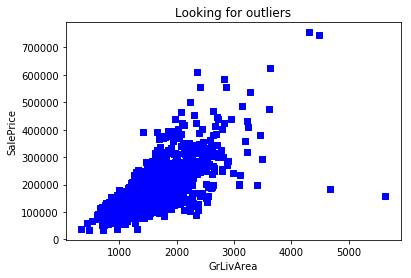

In [32]:
plt.scatter(int_columns.GrLivArea, int_columns.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

In [33]:
object_columns = object_columns[int_columns.GrLivArea < 4500]
int_columns = int_columns[int_columns.GrLivArea < 4500]

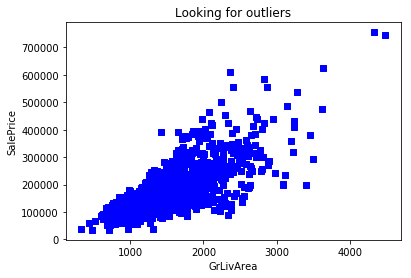

In [34]:
plt.scatter(int_columns.GrLivArea, int_columns.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

## Skewness

Firstly, we visualize the distributions of each numerical variable to see if it follows ormal distribution, or if it should be normalized

C:\Users\Infernal\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
C:\Users\Infernal\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Infernal\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  r

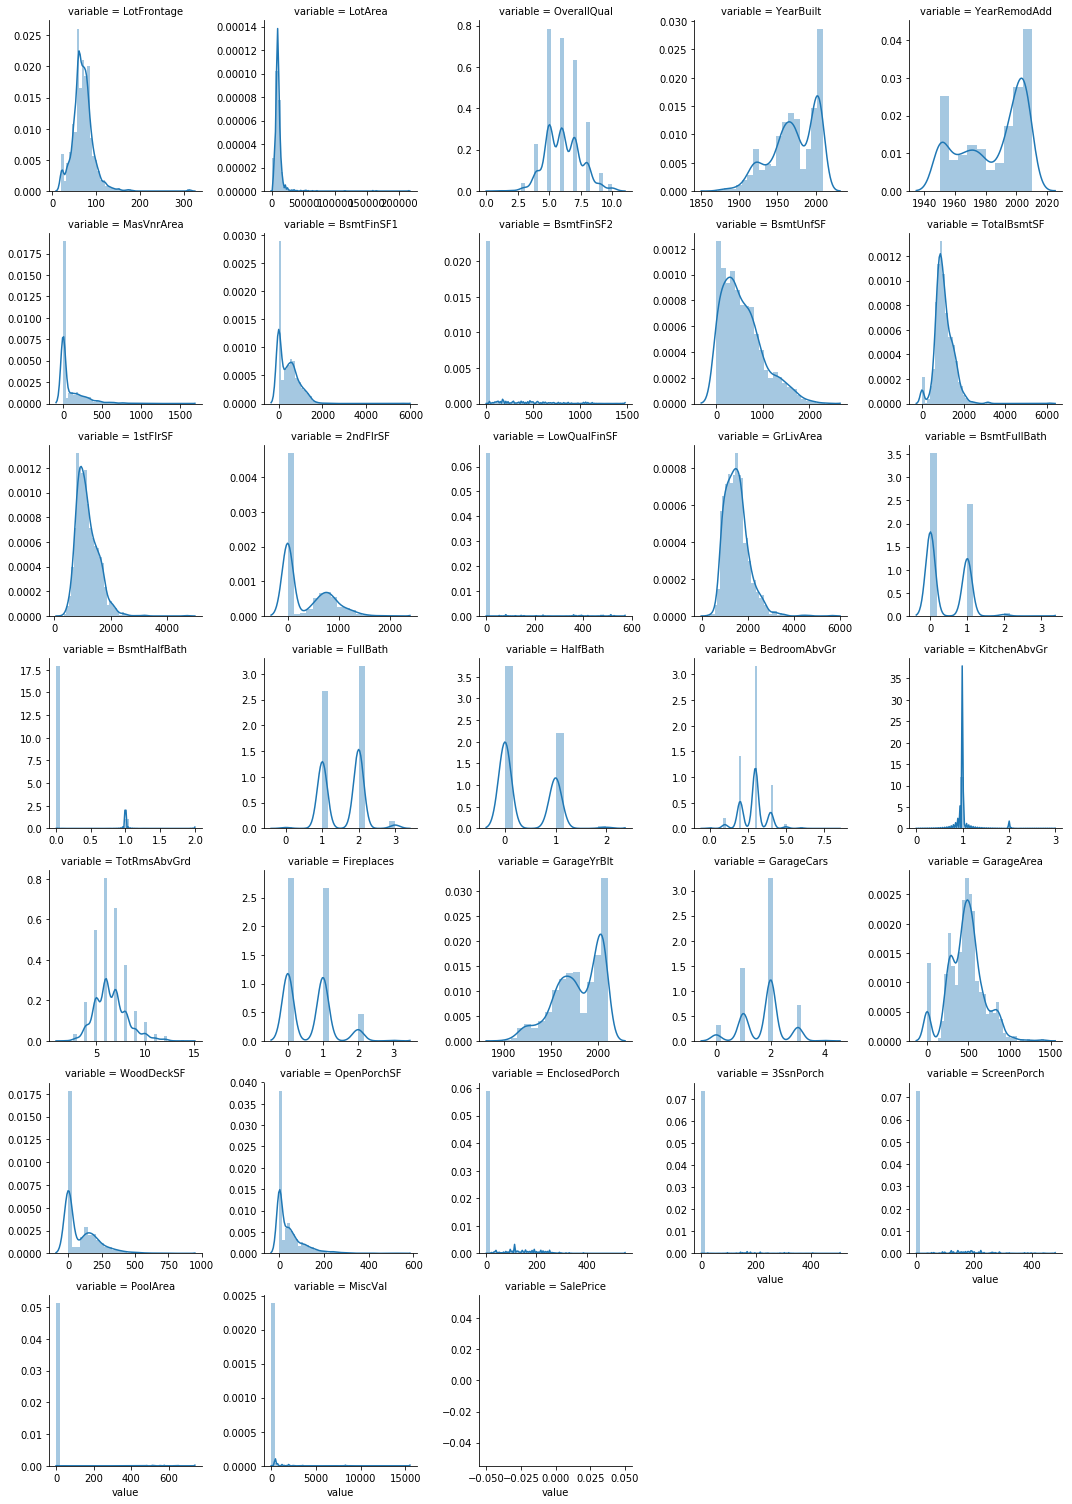

In [35]:
f = pd.melt(train, value_vars=int_columns)
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

We can easily see that non of the distributions are normal and thus the should be normalized<br>
Due to drops in the end result, I kept them as they are. Nevertheless, the correct choice should have been to correct their skewness

In [59]:
skewed_feats = int_columns.apply(lambda x: abs(skew(x.dropna()))).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew': skewed_feats})
skewness[0:10]


Skew in numerical features: 



,Skew
MiscVal,24.434913
PoolArea,15.932532
LotArea,12.560986
3SsnPorch,10.286510
LowQualFinSF,8.995688
KitchenAbvGr,4.480268
BsmtFinSF2,4.247550
ScreenPorch,4.114690
BsmtHalfBath,4.095895
GarageYrBlt,3.862401


In [60]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index

There are 33 skewed numerical features to Box Cox transform


In [61]:
lam = 0.15
# for feat in skewed_features:
#     if feat == 'SalePrice': continue
#     int_columns[feat] = boxcox1p(int_columns[feat], lam)

In [62]:
skewed_feats = int_columns.apply(lambda x: abs(skew(x.dropna()))).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew': skewed_feats})
skewness[0:10]


Skew in numerical features: 



,Skew
MiscVal,24.434913
PoolArea,15.932532
LotArea,12.560986
3SsnPorch,10.286510
LowQualFinSF,8.995688
KitchenAbvGr,4.480268
BsmtFinSF2,4.247550
ScreenPorch,4.114690
BsmtHalfBath,4.095895
GarageYrBlt,3.862401


## Fix SalesPrice

Here we will normalize the important target variable so that we get better predictions afterwards.

C:\Users\Infernal\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


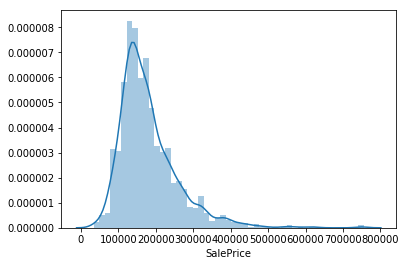

In [63]:
sns.distplot(int_columns["SalePrice"], kde=True)

In [64]:
train_ds = object_columns.join(int_columns)
test_ds = test_object_columns.reset_index(drop=True).join(test_int_columns)

train_ds["SalePrice"] = np.log1p(train_ds["SalePrice"])

C:\Users\Infernal\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


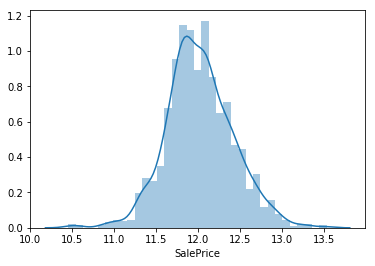

In [65]:
sns.distplot(np.log1p(int_columns["SalePrice"]), kde=True)

## Adding Features

Here we can create a new variable with the total square feat for a house. <br>
We try to create the most columns possible, as the final algorithm will judge which are worthy enough.

In [66]:
train_ds.insert(loc=0, column='TotalSF', value=(train_ds['TotalBsmtSF'] + train_ds['1stFlrSF'] + train_ds['2ndFlrSF']))
test_ds.insert(loc=0, column='TotalSF', value=(test_ds['TotalBsmtSF'] + test_ds['1stFlrSF'] + test_ds['2ndFlrSF']))

## Removing Features

Here I tried to remove features with the help of PCA and Lasso<br>
However, every attempt to reduce even a few of the dimensions resulted in the drop of the final score,
so I deleted.

## Create Final Dataset

Here we create the final sets which we will use for training and predictions

In [78]:
X_train = pd.DataFrame(train_ds.values[:,:-1])
y_train = pd.DataFrame(train_ds.values[:,-1])
X_test = pd.DataFrame(test_ds)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(1458, 221)
(1458, 1)
(1459, 221)


Importing all usefull libraries to be able to perform most regressions.<br>
Other noteworthy ones are the RobustScaler and the Pipeline<br>
The pipeline can connect an algorithm to some functions, in our case the robust scaler.<br>
Together they will first scale the data to remove any soft outliers that we could not detect and then fit the corresponding algorithm.

In [47]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge, BayesianRidge, LassoLarsIC, SGDRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

C:\Users\Infernal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


This is a function for kfold validation. We do this to get a more robust idea of how our algorithm really performs

In [48]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train.values.ravel(), scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

Here are implementations of various regression algorithms we already learned, on the scaled set.

In [79]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
eNet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
ridge = Ridge(alpha=60)
svr = SVR(gamma= 0.0004,kernel='rbf',C=13,epsilon=0.009)
ker = KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=0.8)
bay = BayesianRidge()

From here on we use boosting.<br>
The hyperparameters are taken directly for another kernel but I couldn't find anything performing better through brute forcing a lot of variations

In [80]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [81]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [82]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

Here I cross validate those algorithms

In [84]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1128 (0.0069)



In [85]:
score = rmsle_cv(eNet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1128 (0.0070)



In [86]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1175 (0.0087)



In [87]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1152 (0.0065)



In [88]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1142 (0.0068)



This class initalize some of the model described above and attemps to average the estimators in hope for a better final one. However, it does not manage to perform much better than any of the single estimators above

In [90]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [91]:
averaged_models = AveragingModels(models = (lasso, eNet))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1128 (0.0070)



Here we try to perform stacking; That is, taking the output of one algorithm and feeding it to another again hoping for a better result.

In [69]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

The results from here one are much better and can be used for ensembling<br>
The strategy from here on, is to use elastic Net and GBoost and then feed it to a lasso<br>
Lastly, we create one last weighted estimator, using the boosted and stacked algorithms
(Ensembling)

In [70]:
stacked_averaged_models = StackingAveragedModels(base_models = (eNet, GBoost),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1087 (0.0067)


In [71]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [72]:
stacked_averaged_models.fit(X_train.values, y_train.values.ravel())
stacked_train_pred = stacked_averaged_models.predict(X_train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(X_test.values))
print(rmsle(y_train.values.ravel(), stacked_train_pred))

0.07799742049090083


In [73]:
model_xgb.fit(X_train.values, y_train.values.ravel())
xgb_train_pred = model_xgb.predict(X_train.values)
xgb_pred = np.expm1(model_xgb.predict(X_test.values))
print(rmsle(y_train.values.ravel(), xgb_train_pred))

0.08125283629741045


In [74]:
model_lgb.fit(X_train.values, y_train.values.ravel())
lgb_train_pred = model_lgb.predict(X_train.values)
lgb_pred = np.expm1(model_lgb.predict(X_test.values))
print(rmsle(y_train.values.ravel(), lgb_train_pred))

0.07215542793309415


In [75]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.07560546024803037


In [76]:
ensemble = stacked_pred*0.7 + xgb_pred*0.15+ lgb_pred*0.15

In [77]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = xgb_pred
sub.to_csv('submission.csv',index=False)